In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

# Import SimCLR and relevant libraries
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K

In [ ]:
# SimCLR architecture
def create_simclr_model(base_model, projection_units=256):
    inputs = Input(shape=base_model.input_shape[1:])
    h = base_model(inputs)
    h = Flatten()(h)
    z = Dense(projection_units)(h)
    z = Lambda(lambda x: K.l2_normalize(x, axis=1))(z)

    model = Model(inputs, z)
    return model

In [ ]:
# dataset https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset

# https://www.kaggle.com/code/mdasifmunshe/lung-cancer-detection-using-cnnandresnet50

In [ ]:
directory = r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


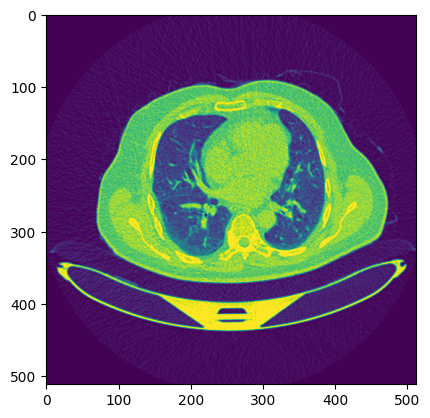

Malignant cases


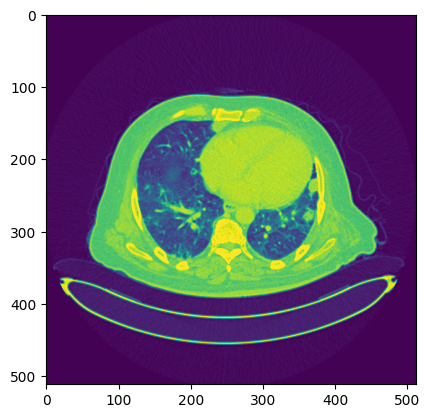

Normal cases


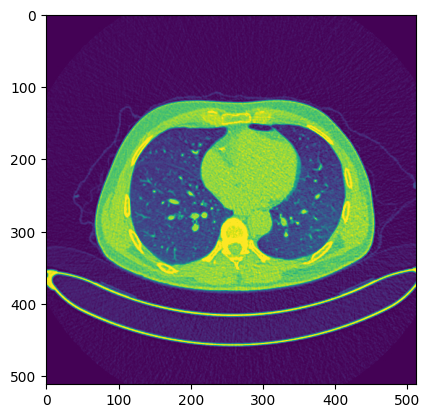

In [ ]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break



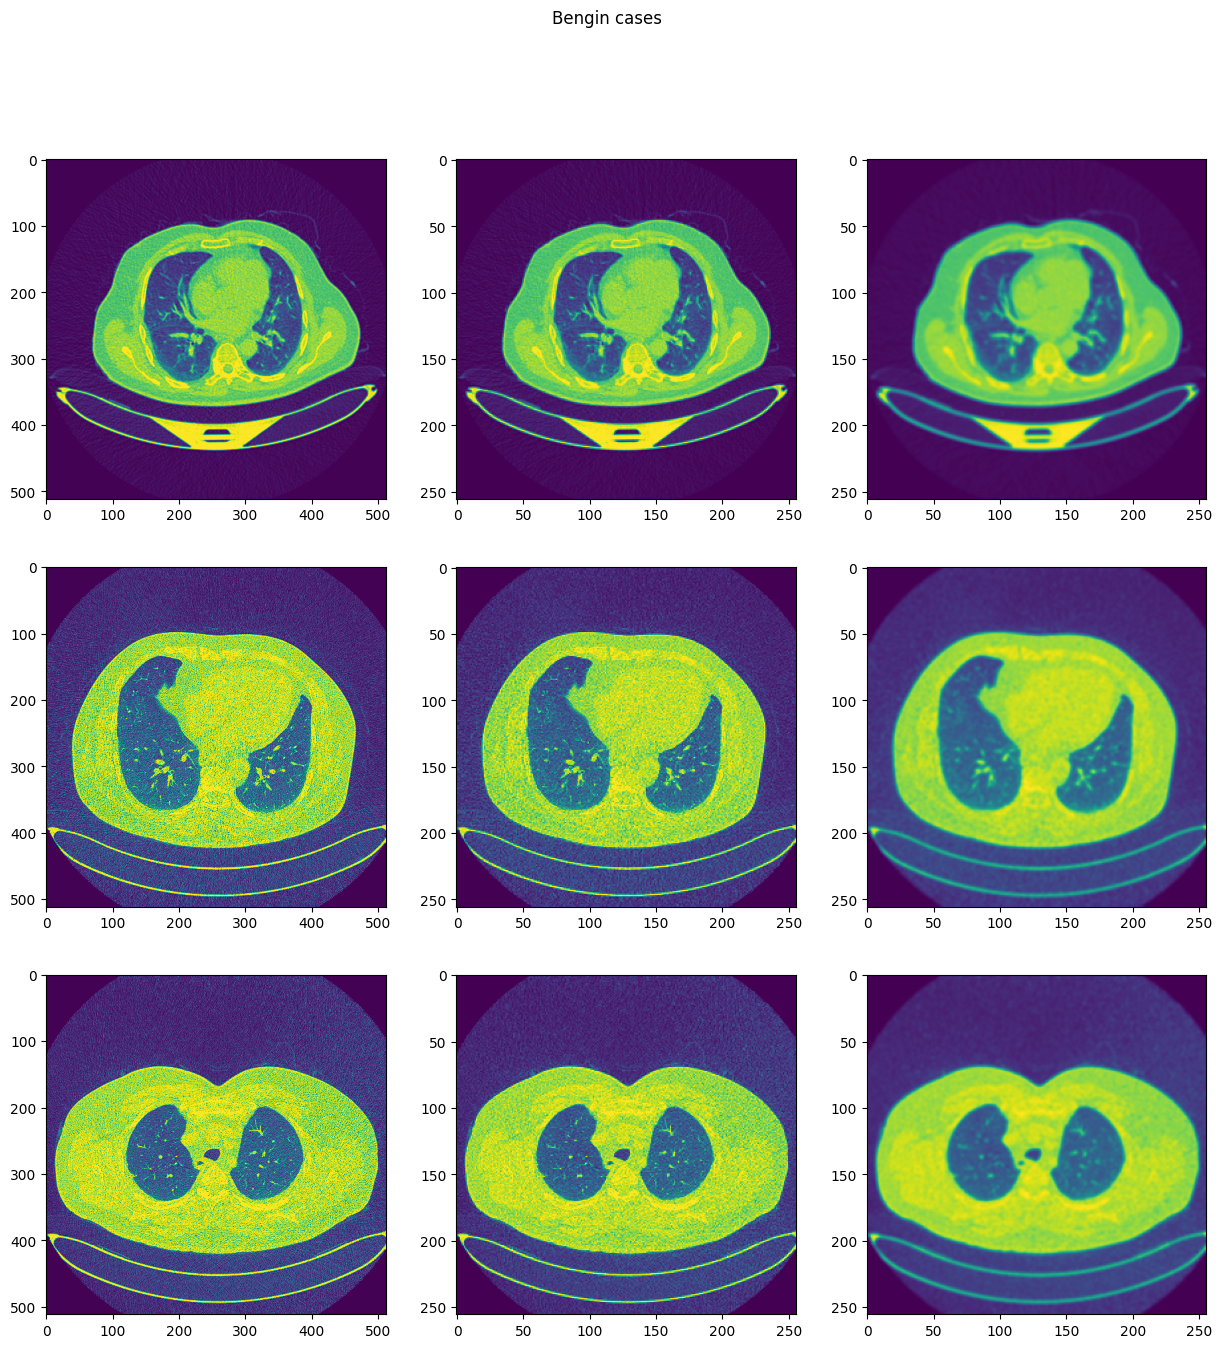

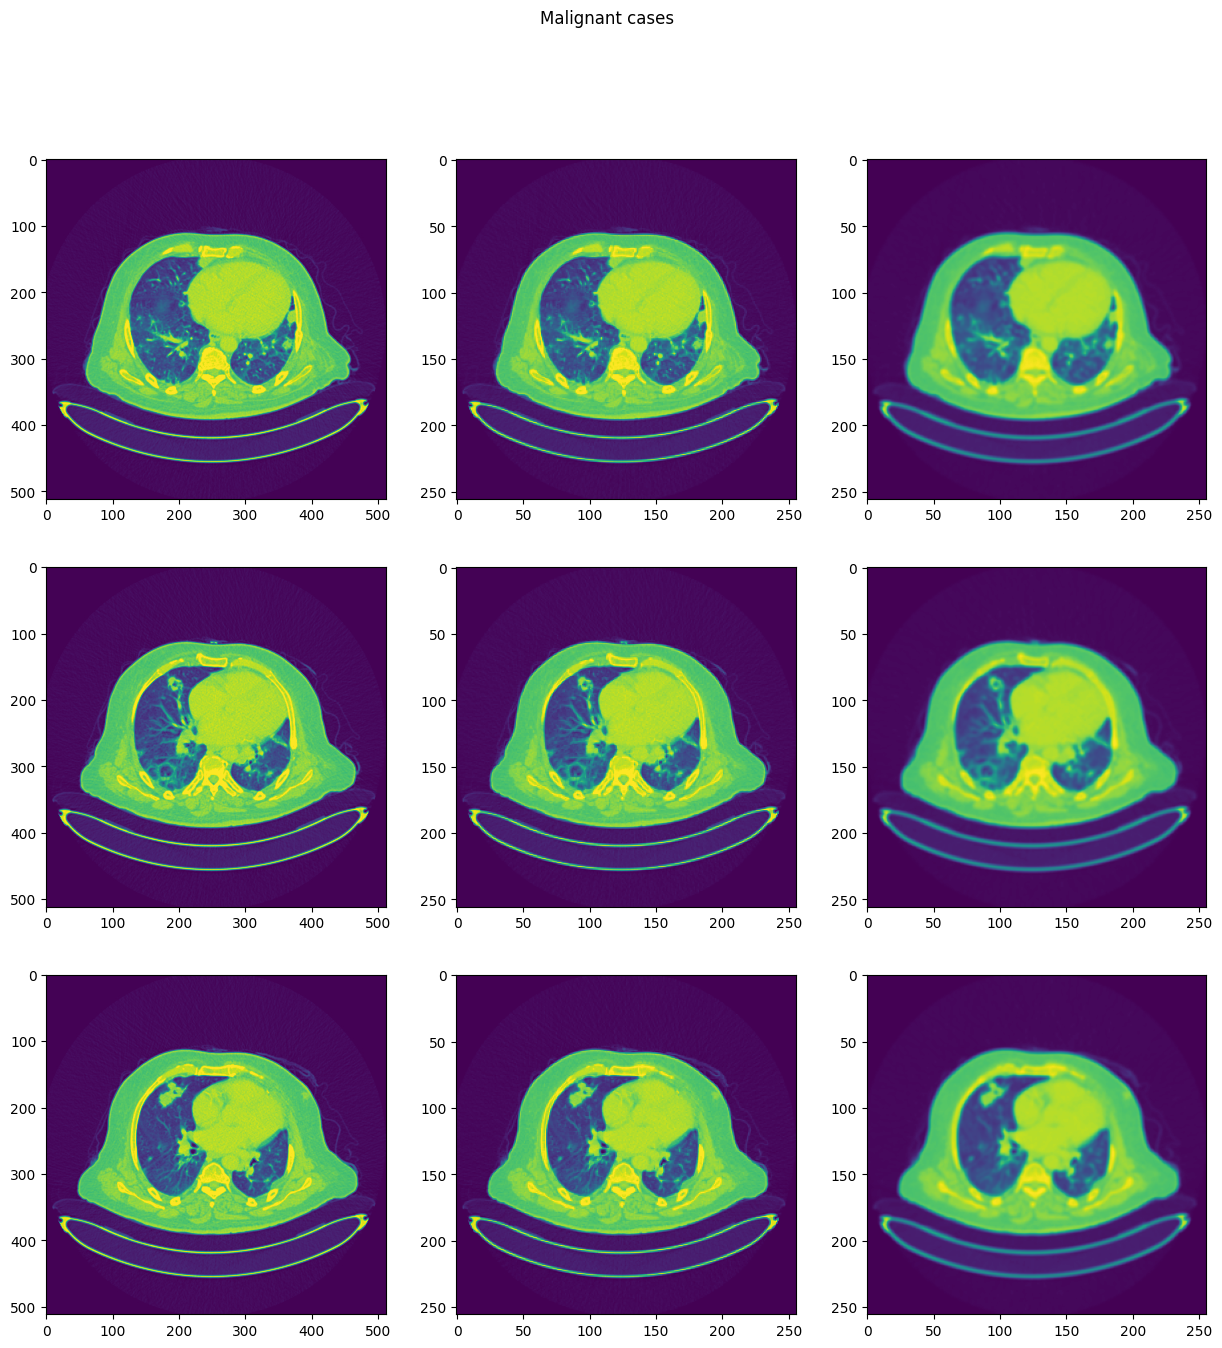

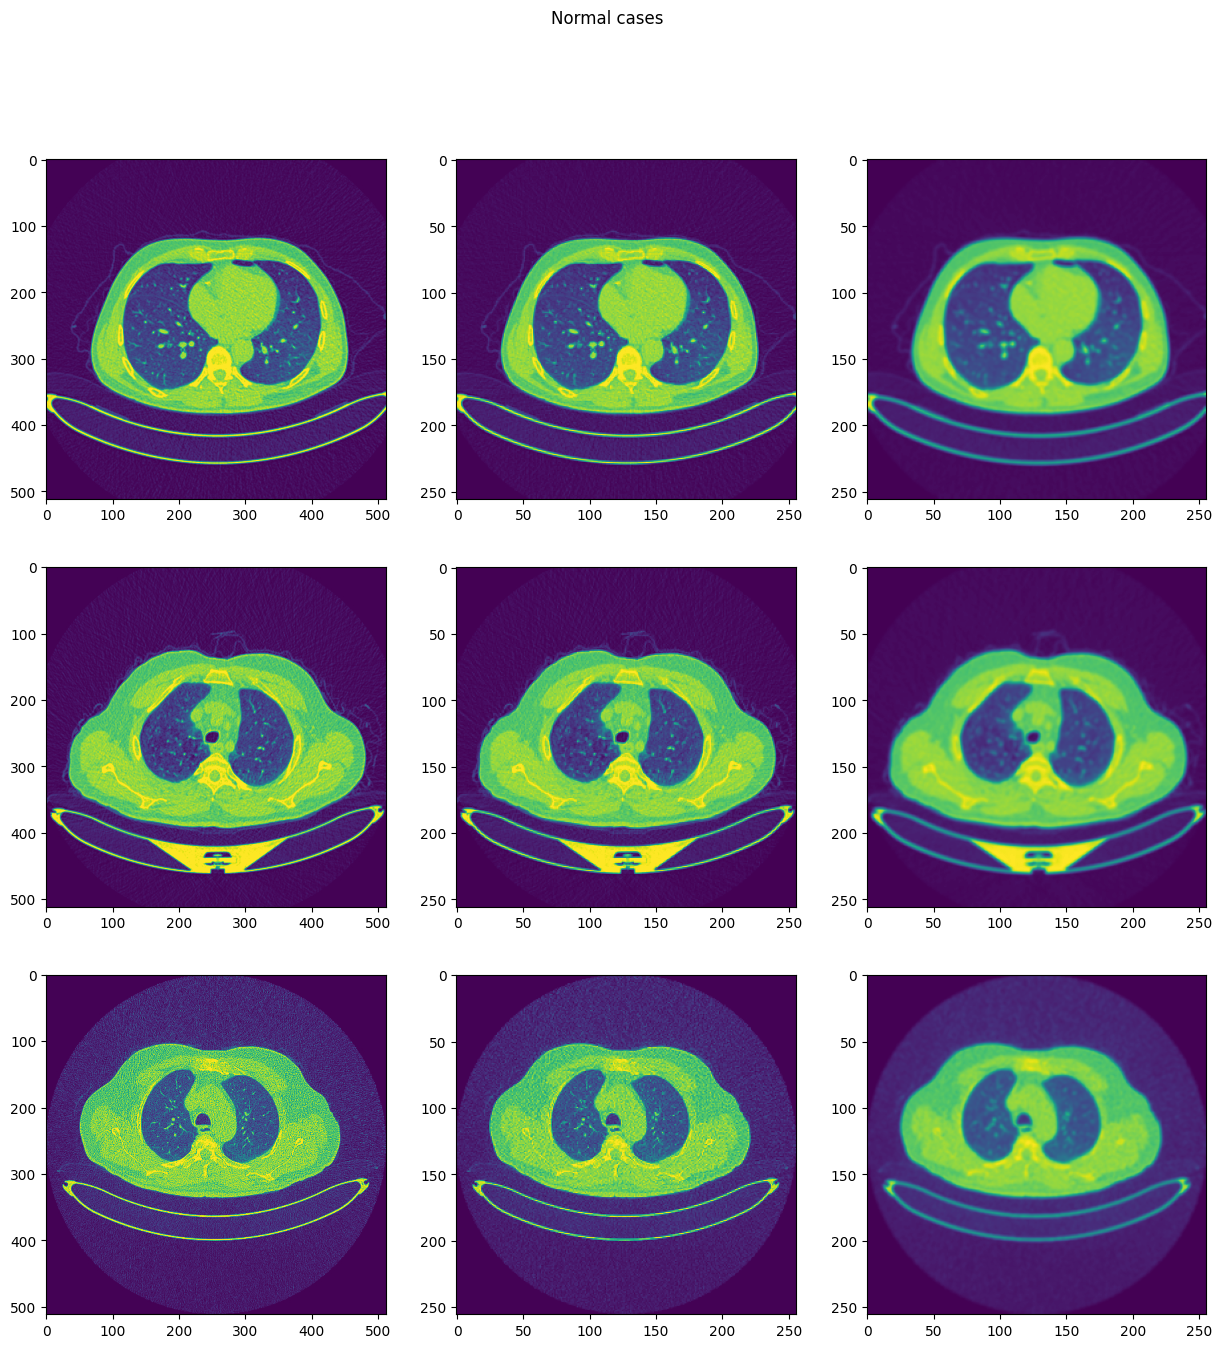

In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 428, 2: 302, 0: 92}) Counter({1: 133, 2: 114, 0: 28})


In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 428, 2: 302, 0: 92})
After SMOTE: Counter({2: 428, 1: 428, 0: 428})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1284 (1284, 256, 256, 1)


In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=4, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=4, shuffle=True)

In [ ]:
# simple early stopping
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Load the pre-trained ResNet50 model without the top classification layer
resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Create SimCLR model based on ResNet50
simclr_model = create_simclr_model(base_model=resnet_base)

# Pretrain SimCLR model using contrastive loss
# Define loss function, optimizer, and callbacks
simclr_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

# Pretraining with SimCLR
simclr_history = simclr_model.fit(train_generator, epochs=13, validation_data=validation_generator, callbacks=[callback])

# After SimCLR pretraining, create the final classification model
# Add classification head on top of SimCLR base
classification_model = Sequential()
classification_model.add(simclr_model)
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(3, activation='softmax'))

# Compile the classification model
classification_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the classification model
classification_history = classification_model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])


Epoch 1/13
206/206 [==============================] - 63s 110ms/step - loss: 3.5338 - val_loss: 3.6195
Epoch 2/13
206/206 [==============================] - 20s 99ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 3/13
206/206 [==============================] - 20s 98ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 4/13
206/206 [==============================] - 20s 96ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 5/13
206/206 [==============================] - 20s 97ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 6/13
206/206 [==============================] - 20s 96ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 7/13
206/206 [==============================] - 20s 97ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 8/13
206/206 [==============================] - 20s 98ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 9/13
206/206 [==============================] - 21s 101ms/step - loss: 3.4644 - val_loss: 3.6195
Epoch 10/13
206/206 [==============================] - 20s 97ms/step - loss: 3.4

In [ ]:
y_pred = classification_model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 212ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       0.99      1.00      0.99       133
           2       1.00      0.95      0.97       114

    accuracy                           0.98       275
   macro avg       0.95      0.98      0.97       275
weighted avg       0.98      0.98      0.98       275

[[ 28   0   0]
 [  0 133   0]
 [  4   2 108]]


In [ ]:
import cv2

# Load and preprocess the image you want to predict
def preprocess_image(image_path, img_size=256):
    img = cv2.imread(image_path, 0)  # Load the image (grayscale in this case)
    img = cv2.resize(img, (img_size, img_size))  # Resize to the model's input size
    img = img / 255.0  # Normalize pixel values (if not done during training)
    img = img.reshape(1, img_size, img_size, 1)  # Reshape for model input
    return img

# Specify the path to the image you want to predict
image_path = '/content/000001_03_01_088.png'

# Preprocess the image
input_image = preprocess_image(image_path)

# Use the trained classification model to make predictions
predictions = classification_model.predict(input_image)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)

# Map the class label to the actual class name
class_names = ['Bengin', 'Malignant', 'Normal']  # Update with your class names
predicted_class_name = class_names[predicted_class[0]]

print(f'Predicted Class: {predicted_class_name}')


1/1 [==============================] - 0s 38ms/step
Predicted Class: Normal
